In [2]:
!pip install pandas keras sklearn matplotlib tqdm gcsfs plotly==4.1.0 notebook>=5.3 ipywidgets>=7.5

You are using pip version 19.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# 載入所需套件
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import datetime, time, csv
from tqdm import tqdm
# import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [4]:
df_train = pd.read_csv('./T-BrainAI_dataset/train.csv', encoding='big5')
Y_df_train = df_train[['Y1']]
Y_df_train['result'] = Y_df_train['Y1'].apply(lambda x: 1 if x == 'Y' else 0)
Y_df_train = Y_df_train.drop(['Y1'], axis=1)
# df_train = df_train[df_train.columns.difference(['Y1'])]
df_train

,CUS_ID,GENDER,AGE,CHARGE_CITY_CD,CONTACT_CITY_CD,EDUCATION_CD,MARRIAGE_CD,LAST_A_CCONTACT_DT,L1YR_A_ISSUE_CNT,LAST_A_ISSUE_DT,...,L1YR_GROSS_PRE_AMT,CUST_9_SEGMENTS_CD,FINANCETOOLS_A,FINANCETOOLS_B,FINANCETOOLS_C,FINANCETOOLS_D,FINANCETOOLS_E,FINANCETOOLS_F,FINANCETOOLS_G,Y1
0,3418,M,低,A1,A1,NaN,NaN,Y,0,N,...,0.000174,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,4302,M,低,A1,A1,NaN,NaN,Y,0,N,...,0.008724,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,5545,M,低,A1,A1,1.0,0.0,Y,1,Y,...,0.005359,A,Y,N,N,N,N,N,N,N
3,7207,M,低,A1,A1,NaN,0.0,Y,0,N,...,0.000000,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,7213,M,低,A1,A1,1.0,0.0,N,0,N,...,0.000603,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2525675,F,高,A1,A1,3.0,0.0,N,0,N,...,0.000439,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
99996,2534462,F,高,E,E,1.0,0.0,Y,0,N,...,0.000000,H,N,N,Y,N,N,N,N,Y
99997,2535679,F,中高,C2,C2,2.0,1.0,Y,0,N,...,0.000000,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
99998,2544819,M,高,A1,A1,3.0,1.0,Y,0,Y,...,0.000504,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [5]:
Y_df_train

,result
0,0
1,0
2,0
3,0
4,0
...,...
99995,0
99996,1
99997,1
99998,0


In [6]:
df_test = pd.read_csv('./T-BrainAI_dataset/test.csv', encoding='big5')
df_test

,CUS_ID,GENDER,AGE,CHARGE_CITY_CD,CONTACT_CITY_CD,EDUCATION_CD,MARRIAGE_CD,LAST_A_CCONTACT_DT,L1YR_A_ISSUE_CNT,LAST_A_ISSUE_DT,...,IF_ADD_INSD_IND,L1YR_GROSS_PRE_AMT,CUST_9_SEGMENTS_CD,FINANCETOOLS_A,FINANCETOOLS_B,FINANCETOOLS_C,FINANCETOOLS_D,FINANCETOOLS_E,FINANCETOOLS_F,FINANCETOOLS_G
0,1193,M,低,A1,A1,2.0,0.0,Y,4,Y,...,Y,0.000151,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1727,M,低,A1,A1,NaN,0.0,N,0,N,...,N,0.000000,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3293,M,低,A1,A1,1.0,0.0,N,0,N,...,N,0.000090,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4328,M,低,A1,A1,NaN,0.0,N,0,N,...,N,0.000000,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5555,M,低,A1,A1,1.0,0.0,Y,0,Y,...,N,0.000179,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,2074085,F,中高,A1,A1,3.0,0.0,Y,0,N,...,NaN,0.000122,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149996,2095927,F,高,B1,B1,3.0,1.0,Y,1,Y,...,NaN,0.000104,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149997,2125973,M,高,C1,C1,3.0,1.0,Y,0,N,...,NaN,0.000225,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149998,2511714,F,高,D,D,3.0,1.0,Y,0,N,...,NaN,0.000000,H,Y,N,N,N,N,N,N


In [64]:
# df_train_t = df_train.copy()
# df_train_t['Y1'] = df_train['Y1'].apply(lambda x: 1 if x == 'Y' else 0)

# # https://blog.csdn.net/dss_dssssd/article/details/82811300
# corr_metrix = df_train_t.corr()
# train_class_weight_posi = corr_metrix['Y1'].sort_values(ascending=False)[:30]
# train_class_weight_nega = corr_metrix['Y1'].sort_values(ascending=False)[39:]

# train_class_weight_posi = train_class_weight_posi.reset_index()
# train_class_weight_posi['weight'] = (1 / (train_class_weight_posi['Y1']*100))
# train_class_weight_posi['weight'] = 1 / train_class_weight_posi['weight']

# train_class_weight_nega = train_class_weight_nega.reset_index()
# train_class_weight_nega['weight'] = (1 / (train_class_weight_nega['Y1']*100))
# train_class_weight_nega['weight'] = 1 / train_class_weight_nega['weight']
# train_class_weight = pd.concat([train_class_weight_posi, train_class_weight_nega])
# train_class_weight = train_class_weight[['index', 'Y1', 'weight']]
train_class_weight

,index,Y1,weight
0,Y1,1.000000,100.000000
1,L1YR_A_ISSUE_CNT,0.121897,12.189659
2,AG_NOW_CNT,0.101031,10.103079
3,CHANNEL_A_POL_CNT,0.096635,9.663517
4,TOOL_VISIT_1YEAR_CNT,0.094471,9.447141
5,LEVEL,0.093061,9.306067
6,CLC_CUR_NUM,0.084761,8.476071
7,BANK_NUMBER_CNT,0.074727,7.472735
8,LIFE_INSD_CNT,0.072510,7.251016
9,IM_CNT,0.071781,7.178148


In [85]:
# bbb = []
# for f in df_train_t.columns:
#     if (type(df_train_t[f][0]) == str):
#         bbb.append(f)
# print(f'{len(bbb)} Non-num Features : {bbb}\n')

# bb = df_train_t[bbb]
# bbb_temp = pd.DataFrame()
# for c in bb.columns:
#     try:
#         bbb_temp[c] = LabelEncoder().fit_transform(bb[c])
#     except TypeError as a:
#         print(a)

# bbbb_temp = pd.concat([bbb_temp, df_train_t], axis=1)
# corr_metrix_b = bbbb_temp.corr()
# co = corr_metrix_b['Y1'].sort_values(ascending=False).reset_index()
# co_weight = co[(co['Y1'] >= 0.05) | (co['Y1'] <= -0.05)]
# co_weight['weight'] = (1 / (co_weight['Y1']*100))
# co_weight['weight'] = 1 / co_weight['weight']
# class_weight = pd.concat([co_weight, train_class_weight])
# class_weight = class_weight.drop_duplicates()
# # https://stackoverflow.com/questions/26716616/convert-a-pandas-dataframe-to-a-dictionary
# class_weight = class_weight.set_index('index').T.to_dict('records')[1]
class_weight

{'Y1': 100.0,
 'LAST_A_ISSUE_DT': 12.25495137004375,
 'L1YR_A_ISSUE_CNT': 12.189659409194281,
 'IF_ISSUE_I_IND': 10.305024456616001,
 'LAST_A_CCONTACT_DT': 10.259677985713044,
 'AG_NOW_CNT': 10.103078510347261,
 'IF_ISSUE_Q_IND': 9.783821318611057,
 'CHANNEL_A_POL_CNT': 9.6635167192177,
 'TOOL_VISIT_1YEAR_CNT': 9.447141330310641,
 'IF_ADD_Q_IND': 9.406823613654266,
 'IF_ADD_L_IND': 9.402499899296357,
 'LEVEL': 9.306067376719433,
 'IF_ADD_IND': 9.016811772506873,
 'CLC_CUR_NUM': 8.476070667605912,
 'BANK_NUMBER_CNT': 7.472734911897895,
 'IF_ISSUE_J_IND': 7.464773664536754,
 'LIFE_INSD_CNT': 7.251015968307341,
 'LAST_C_DT': 7.223382055592839,
 'IM_CNT': 7.178148299146726,
 'EDUCATION_CD': 7.099429637323633,
 'DIEACCIDENT_AMT': 6.711022523894751,
 'IF_ADD_R_IND': 6.66061126464619,
 'RFM_M_LEVEL': 6.624425089089886,
 'AG_CNT': 6.532733981875202,
 'IM_IS_B_IND': 5.929916132455532,
 'INSD_CNT': 5.608870763042286,
 'DIEBENEFIT_AMT': 5.343489855180282,
 'BMI': 5.196349291523532,
 'IF_ISSUE_P_I

In [219]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
# fill_values = {'GENDER': 'None', 'EDUCATION_CD': 3.0, 'MARRIAGE_CD': 0.0, 'OCCUPATION_CLASS_CD': 1.0, 'APC_1ST_AGE': '中高', 'APC_1ST_YEARDIF': 0.2587685984593603, 'RFM_R': '低', 'REBUY_TIMES_CNT': '低', 'LEVEL': 5.0, 'RFM_M_LEVEL': 3.0, 'LIFE_CNT': '低', 'ANNUAL_INCOME_AMT': 0.0006068425456175268, 'L1YR_PAYMENT_REMINDER_IND': 'N', 'BMI': 0.275, 'TERMINATION_RATE': 12.090984696216369} # 填眾數
# df_train = df_train.fillna(value=fill_values)
# df_test = df_test.fillna(value=fill_values)
# df_train.groupby(['INSD_LAST_YEARDIF_CNT']).count()
df_train['INSD_LAST_YEARDIF_CNT'].mean()

0.1724875816240972

In [243]:
# select features
selected_features = ['CUS_ID', 'L1YR_A_ISSUE_CNT', 'L1YR_A_ISSUE_CNT', 'IF_ISSUE_I_IND', 'LAST_A_CCONTACT_DT', 'AG_NOW_CNT', 
                     'IF_ISSUE_Q_IND', 'CHANNEL_A_POL_CNT', 'TOOL_VISIT_1YEAR_CNT', 'IF_ADD_Q_IND', 'IF_ADD_L_IND', 'LEVEL', 'IF_ADD_IND', 
                     'CLC_CUR_NUM', 'BANK_NUMBER_CNT', 'IF_ISSUE_J_IND', 'LIFE_INSD_CNT', 'LAST_C_DT', 'IM_CNT', 'EDUCATION_CD',
                     'INSD_LAST_YEARDIF_CNT', 'IF_2ND_GEN_IND', 'APC_CNT', 'TERMINATION_RATE', 'APC_1ST_YEARDIF', 'AGE']

# fill_values = {'GENDER': 'None', 'EDUCATION_CD': 3.0, 'MARRIAGE_CD': 0.0, 'OCCUPATION_CLASS_CD': 1.0, 'APC_1ST_AGE': '中高', 'APC_1ST_YEARDIF': 0.2587685984593603, 'RFM_R': '低', 'REBUY_TIMES_CNT': '低', 'LEVEL': 5.0, 'RFM_M_LEVEL': 3.0, 'LIFE_CNT': '低', 'ANNUAL_INCOME_AMT': 0.0006068425456175268, 'L1YR_PAYMENT_REMINDER_IND': 'N', 'BMI': 0.275, 'TERMINATION_RATE': 12.090984696216369} # 填眾數
fill_values = {
    'INSD_LAST_YEARDIF_CNT': 0.1724875816240972,
    'EDUCATION_CD': 3.0, 
    'APC_1ST_YEARDIF': 0.2587685984593603, 
    'LEVEL': 5.0, 
    'TERMINATION_RATE': 12.090984696216369
}

df_train = df_train.fillna(value=fill_values)
df_test = df_test.fillna(value=fill_values)

df_train = df_train[selected_features]
df_test = df_test[selected_features]

print(df_train.isnull().sum())

CUS_ID                   0
L1YR_A_ISSUE_CNT         0
L1YR_A_ISSUE_CNT         0
IF_ISSUE_I_IND           0
LAST_A_CCONTACT_DT       0
AG_NOW_CNT               0
IF_ISSUE_Q_IND           0
CHANNEL_A_POL_CNT        0
TOOL_VISIT_1YEAR_CNT     0
IF_ADD_Q_IND             0
IF_ADD_L_IND             0
LEVEL                    0
IF_ADD_IND               0
CLC_CUR_NUM              0
BANK_NUMBER_CNT          0
IF_ISSUE_J_IND           0
LIFE_INSD_CNT            0
LAST_C_DT                0
IM_CNT                   0
EDUCATION_CD             0
INSD_LAST_YEARDIF_CNT    0
IF_2ND_GEN_IND           0
APC_CNT                  0
TERMINATION_RATE         0
APC_1ST_YEARDIF          0
AGE                      0
dtype: int64


In [244]:
#只取非數值欄位做編碼轉換
nonNum_features = []
for feature in df_train.columns:
    try:
        if (type(df_train[feature][0]) == str):
            nonNum_features.append(feature)
    except TypeError as e:
        print(e)
#         nonNum_features.append(feature)

print(f'{len(nonNum_features)} Non-num Features : {nonNum_features}\n')

df_train_obj = df_train[nonNum_features]
df_train_obj = df_train_obj.fillna('None')
df_test_obj = df_test[nonNum_features]
df_test_obj = df_test_obj.fillna('None')
Num_feature = selected_features.copy()
for b in nonNum_features:
    Num_feature.remove(b)
Num_feature.remove('CUS_ID')

df_train_obj_temp = pd.DataFrame()
df_test_obj_temp = pd.DataFrame()
for c in df_train_obj.columns:
    df_train_obj_temp[c] = LabelEncoder().fit_transform(df_train_obj[c])
    
for c in df_test_obj.columns:
    df_test_obj_temp[c] = LabelEncoder().fit_transform(df_test_obj[c])

# # data normalization
# X_train = df_train[Num_feature].values.copy()
# Y_train = Y_df_train['result'].values.copy()
# X_test = df_test[Num_feature].values.copy()
# # X_test = df_test[df_test.columns.difference(nonNum_features)].values.copy()
# # https://stackoverflow.com/questions/14940743/selecting-excluding-sets-of-columns-in-pandas

# for col, i in zip(X_train.columns, range(X_train.shape[1])):
#     X_train[col] = X_train[col].apply(lambda x: x - np.mean(X_train[col]))
#     X_train[col] = X_train[col].apply(lambda x: x - np.std(X_train[col]))
#     X_test[col] = X_test[col].apply(lambda x: x - np.mean(X_test[col]))
#     X_test[col] = X_test[col].apply(lambda x: x - np.std(X_test[col]))


# for i in range(X_train.shape[1]):
#     X_train[:,i] -= np.mean(X_train[:,i])
#     X_train[:,i] /= np.std(X_train[:,i])
#     X_test[:,i] -= np.mean(X_test[:,i])
#     X_test[:,i] /= np.std(X_test[:,i])

# X_train = pd.DataFrame(data=X_train, columns=Num_feature)
# X_test = pd.DataFrame(data=X_test, columns=Num_feature)

X_train = df_train[Num_feature]
X_test = df_test[Num_feature]
train_ID = df_train[['CUS_ID']]
test_ID = df_test[['CUS_ID']]

df_trainL = pd.concat([df_train_obj_temp, X_train], axis=1)
df_testL = pd.concat([df_test_obj_temp, X_test], axis=1)

df_trainL

'<' not supported between instances of 'str' and 'int'
'<' not supported between instances of 'str' and 'int'
10 Non-num Features : ['IF_ISSUE_I_IND', 'LAST_A_CCONTACT_DT', 'IF_ISSUE_Q_IND', 'IF_ADD_Q_IND', 'IF_ADD_L_IND', 'IF_ADD_IND', 'IF_ISSUE_J_IND', 'LAST_C_DT', 'IF_2ND_GEN_IND', 'AGE']



,IF_ISSUE_I_IND,LAST_A_CCONTACT_DT,IF_ISSUE_Q_IND,IF_ADD_Q_IND,IF_ADD_L_IND,IF_ADD_IND,IF_ISSUE_J_IND,LAST_C_DT,IF_2ND_GEN_IND,AGE,...,LEVEL,CLC_CUR_NUM,BANK_NUMBER_CNT,LIFE_INSD_CNT,IM_CNT,EDUCATION_CD,INSD_LAST_YEARDIF_CNT,APC_CNT,TERMINATION_RATE,APC_1ST_YEARDIF
0,0,1,0,0,0,0,0,0,0,2,...,3.0,0,0.125,0.015625,0,3.0,0.052632,0,0.0,0.046512
1,0,1,0,0,0,0,0,0,0,2,...,5.0,0,0.125,0.015625,0,3.0,0.052632,0,0.0,0.046512
2,0,1,0,0,0,0,0,0,1,2,...,5.0,1,0.000,0.031250,0,1.0,0.000000,1,0.0,0.000000
3,0,1,0,0,0,0,0,0,0,2,...,5.0,0,0.125,0.015625,0,3.0,0.210526,0,0.0,0.162791
4,0,0,0,0,0,0,0,0,1,2,...,2.0,1,0.000,0.062500,0,1.0,0.078947,1,0.0,0.116279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,3,...,1.0,2,0.000,0.000000,1,3.0,0.172488,0,0.0,0.372093
99996,0,1,0,0,0,0,0,0,0,3,...,5.0,0,0.000,0.000000,1,1.0,0.172488,0,100.0,0.465116
99997,0,1,0,0,0,0,0,0,0,1,...,5.0,0,0.000,0.000000,1,2.0,0.172488,0,50.0,0.279070
99998,0,1,0,0,0,0,0,0,0,3,...,4.0,1,0.125,0.000000,0,3.0,0.172488,0,0.0,0.023256


In [245]:
# transfor to ndarray
df_trainL_v = df_trainL.values.copy()
df_testL_v = df_testL.values.copy()
Y_df_train = Y_df_train['result'].values.copy()

# split data into training set and validation set
X_train = df_trainL_v[:75000]
Y_train = Y_df_train[:75000]
X_val = df_trainL_v[75000:]
Y_val = Y_df_train[75000:]

# one-hot encoding
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

X_train

array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 4.6511628e-02],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 4.6511628e-02],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+02, 1.6279070e-01],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 6.9767440e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.0930230e-01]])

In [246]:
# https://stackoverflow.com/questions/53640858/loss-nan-keras-regression
model = Sequential()
reg = keras.regularizers.l2(0.0058)
model.add(Dense(150, input_dim = int(X_train.shape[1]), activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(7, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# training
history = model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_val, Y_val))

Train on 75000 samples, validate on 25000 samples
Epoch 1/100
75000/75000 [==============================] - 3s 45us/step - loss: 0.1005 - acc: 0.9784 - val_loss: 0.0885 - val_acc: 0.9814
Epoch 2/100
75000/75000 [==============================] - 2s 26us/step - loss: 0.0894 - acc: 0.9795 - val_loss: 0.0841 - val_acc: 0.9814
Epoch 3/100
75000/75000 [==============================] - 2s 26us/step - loss: 0.0881 - acc: 0.9795 - val_loss: 0.0844 - val_acc: 0.9814
Epoch 4/100
75000/75000 [==============================] - 2s 26us/step - loss: 0.0874 - acc: 0.9795 - val_loss: 0.0831 - val_acc: 0.9814
Epoch 5/100
75000/75000 [==============================] - 2s 26us/step - loss: 0.0867 - acc: 0.9795 - val_loss: 0.0833 - val_acc: 0.9814
Epoch 6/100
75000/75000 [==============================] - 2s 27us/step - loss: 0.0862 - acc: 0.9795 - val_loss: 0.0834 - val_acc: 0.9814
Epoch 7/100
75000/75000 [==============================] - 2s 26us/step - loss: 0.0856 - acc: 0.9795 - val_loss: 0.0844 - 

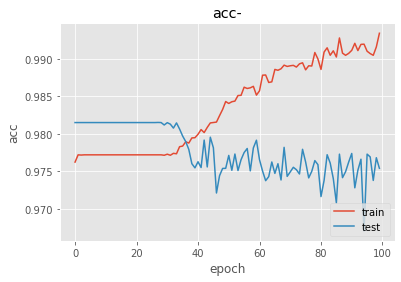

In [236]:
# training process

from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('acc-')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('history_regularization')
plt.show()

In [237]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, Y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
# pred_test= model.predict(df_testL)
# scores2 = model.evaluate(df_testL, y_test, verbose=0)
# print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))

Accuracy on training data: 0.9942285714285715% 
 Error on training data: 0.0057714285714285385


In [239]:
# predict
predicted = np.argmax(model.predict(df_testL), axis = 1)
out_file = 'output_190916_1_adam_categorical_acc.csv'
with open(out_file, 'w') as f:
    f.write('CUS_ID,Ypred\n')
    for i in range(len(predicted)):
        f.write(str(test_ID['CUS_ID'][i])+','+str(predicted[i])+'\n')